In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import *
import xgboost as xgb
import torch
import torch.nn.functional as F
from torch import nn
import torchvision
import gc


In [2]:
# get a list of participant IDs that have soz labels
sozDir = "C:/Users/Xavier Velez/Documents/ECE6254/code/Localising_SOZ_from_SPES/data/main"
sozFiles = os.listdir(sozDir)

sozFiles = sozFiles[1:36]
sozPids = []
for file in sozFiles:
    sozPids.append(int(file[18:20]))


In [ ]:
Fs = 2048
dataDir = "C:/Users/Xavier Velez/Documents/ECE6254/code/autoencoder/CCEP_Project"
allFiles = os.listdir(dataDir)[:-1]

all_bps = np.zeros((1,8))
all_bps_z = np.zeros((1,8))
all_soz = np.zeros((1,))
run_bps = []
run_soz = []
runNames = []
for inst in allFiles:
    # only use participants with soz labels
    pid = int(inst[11:13])
    if pid not in sozPids:
        continue
    
    runNames.append(pid)
    # load the data from the pickle file
    with open(os.path.join(dataDir,inst), 'rb') as file:
        currRun = pickle.load(file)
        
    channel_metrics = {}
    channel_soz = {}
    for event in currRun.keys():
        # get the ECOG data
        event_ecog = currRun[event]['ecog_data']

        # go through all channels
        chan_key_list = list(currRun[event]['ch_info'].keys())
        for chan in chan_key_list:
            # if channel doesn't already exist, initialize with current time series
            if chan not in channel_metrics:
                channel_metrics[chan] = event_ecog[chan_key_list.index(chan),:]
                channel_soz[chan] = currRun[event]['soz_labels'][chan_key_list.index(chan)]
            # if it does exist, concatenate the current ECOG to that channel time series
            else:
                channel_metrics[chan] = np.concatenate((channel_metrics[chan], event_ecog[chan_key_list.index(chan),:]))
    
    channel_bps = np.zeros((8,))
    
    # with all connected time series, find the bandpowers for each channel
    for chan in channel_metrics.keys():
        # take the PSD of the current channel
        chan_psd, chan_freqs = plt.psd(channel_metrics[chan], Fs=2048, NFFT=2**12, detrend='linear', noverlap=2**8, scale_by_freq=False)
        plt.clf()

        # extract relative bandpowers
        totalPower = np.sum(chan_psd[np.where(chan_freqs < 150)])
        delta = np.sum(chan_psd[np.where(chan_freqs < 4)]) / totalPower
        theta = np.sum(chan_psd[np.where((chan_freqs>=4) & (chan_freqs < 8))]) / totalPower
        alpha = np.sum(chan_psd[np.where((chan_freqs>=8) & (chan_freqs < 12))]) / totalPower
        lowbeta = np.sum(chan_psd[np.where((chan_freqs>=12) & (chan_freqs < 20))]) / totalPower
        highbeta = np.sum(chan_psd[np.where((chan_freqs>=20) & (chan_freqs < 30))]) / totalPower
        lowgamma = np.sum(chan_psd[np.where((chan_freqs>=30) & (chan_freqs < 70))]) / totalPower
        highgamma = np.sum(chan_psd[np.where((chan_freqs>=70) & (chan_freqs < 150))]) / totalPower
        
        bp = np.array([delta, theta, alpha, lowbeta, highbeta, lowgamma, highgamma, totalPower])
        channel_bps = np.vstack((channel_bps, bp))

    channel_bps = channel_bps[1:,:]
    channel_bps_z = sp.stats.zscore(channel_bps, axis=1)
    
    run_bps.append(channel_bps)
    run_soz.append(np.array(list(channel_soz.values())))
    
    all_bps = np.vstack((all_bps, channel_bps))
    all_bps_z = np.vstack((all_bps_z, channel_bps_z))
    all_soz = np.concatenate((all_soz, np.array(list(channel_soz.values()))))
    
    print(f"Instance {inst} complete. Number of channels={all_bps_z.shape}. Number of SOZs={all_soz.shape}")


In [3]:
def StackList(inList):
    try:
        outList = np.zeros((1,inList[0].shape[1]))
        for i in range(len(inList)):
            outList = np.vstack((outList, inList[i]))

        outList = outList[1:]
    except:
        outList = np.zeros((1,))
        for i in range(len(inList)):
            outList = np.concatenate((outList, inList[i]))

        outList = outList[1:]
        
    return outList

In [ ]:
pid_bps = []
pid_soz = []

lastRun = ''
for run in range(len(runNames)):
    if runNames[run] != lastRun:
        pid_bps.append(run_bps[run])
        pid_soz.append(run_soz[run])
    else:
        pid_bps[-1] = np.vstack((pid_bps[-1],run_bps[run]))
        pid_soz[-1] = np.concatenate((pid_soz[-1],run_soz[run]))
        
    lastRun = runNames[run]

len(pid_bps), len(pid_soz)

In [ ]:
# save the data in a pickle file
with open("all_bps.pkl", 'wb') as file:
    pickle.dump(all_bps, file)
    
with open("all_soz.pkl", 'wb') as file:
    pickle.dump(all_soz, file)
    
with open("pid_bps.pkl", 'wb') as file:
    pickle.dump(pid_bps, file)
    
with open("pid_soz.pkl", 'wb') as file:
    pickle.dump(pid_soz, file)

In [4]:
# load the data from the pickle files
with open("all_bps.pkl", 'rb') as file:
    all_bps = pickle.load(file)
    
with open("all_soz.pkl", 'rb') as file:
    all_soz = pickle.load(file)
    
with open("pid_bps.pkl", 'rb') as file:
    pid_bps = pickle.load(file)
    
with open("pid_soz.pkl", 'rb') as file:
    pid_soz = pickle.load(file)

# Generate a boxplot of each bandpower

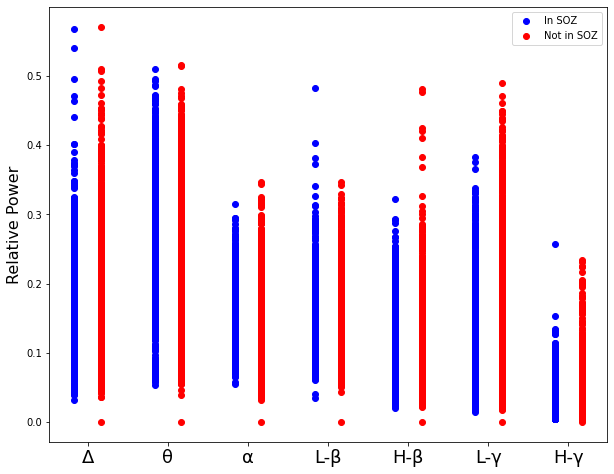

In [5]:
chans_in_soz = all_bps[np.where(all_soz==1)]
chans_not_soz = all_bps[np.where(all_soz==0)]

fig, ax = plt.subplots(figsize=(10,8))
offset = 3
inset = 1
for i in range(all_bps.shape[1]-1):
    inSoz = ax.scatter(inset*np.ones(len(chans_in_soz[:,i])), chans_in_soz[:,i], c='b', label='In SOZ')
    notinSoz = ax.scatter((inset+1)*np.ones(len(chans_not_soz[:,i])), chans_not_soz[:,i], c='r', label='Not in SOZ')
    
    inset += offset

ax.legend(handles = [inSoz, notinSoz])
ax.set_xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5], 
              ['Δ', 'θ', 'α', 'L-β', 'H-β', 'L-γ', 'H-γ'], fontsize=18);
ax.set_ylabel('Relative Power', fontsize=16);


# Binary Classification Using Logistic Regression

In [6]:
n = 5
avg_auroc = []
avg_auprc = []
avg_specificity = []
avg_sensitivity = []
avg_youden = []
avg_conf = np.zeros((2,2))
for state in range(n):
    # split into training and testing sets
    X_train, X_test, t_train, t_test = train_test_split(pid_bps, pid_soz, test_size=0.2, random_state=state)
    X_train = StackList(X_train)
    X_test = StackList(X_test)
    t_train = StackList(t_train)
    t_test = StackList(t_test)
    
    logreg = LogisticRegression(penalty='l2')
    logreg.fit(X_train, t_train)

    t_pred = logreg.predict(X_test)
    
    curr_conf = confusion_matrix(t_test, t_pred)
    tn = curr_conf[0,0]
    fp = curr_conf[0,1]
    fn = curr_conf[1,0]
    tp = curr_conf[1,1]
    
    avg_auroc.append(roc_auc_score(t_test, t_pred))
    avg_auprc.append(average_precision_score(t_test, t_pred))
    avg_specificity.append(tn / (tn+fp))
    avg_sensitivity.append(tp / (tp+fn))
    avg_youden.append(avg_specificity[-1] + avg_sensitivity[-1] - 1)
    
    avg_conf = avg_conf + curr_conf
    
print(f"Average AUROC = {np.mean(avg_auroc)} +/- {np.std(avg_auroc)}")
print(f"Average AUPRC = {np.mean(avg_auprc)} +/- {np.std(avg_auprc)}")
print(f"Average Specificity = {np.mean(avg_specificity)} +/- {np.std(avg_specificity)}")
print(f"Average Sensitivity = {np.mean(avg_sensitivity)} +/- {np.std(avg_sensitivity)}")
print(f"Average Youden = {np.mean(avg_youden)} +/- {np.std(avg_youden)}")
avg_conf

Average AUROC = 0.5003690036900369 +/- 0.0007380073800737907
Average AUPRC = 0.45642197214603647 +/- 0.037213197253932365
Average Specificity = 1.0 +/- 0.0
Average Sensitivity = 0.0007380073800738007 +/- 0.0014760147601476012
Average Youden = 0.0007380073800737907 +/- 0.0014760147601475815


array([[1.743e+03, 0.000e+00],
       [1.455e+03, 1.000e+00]])

# Binary Classification Using SVM

In [7]:
# split into training and validation sets
X_train_cv, X_valid, t_train_cv, t_valid = train_test_split(all_bps, all_soz, test_size=0.25, stratify=all_soz, random_state=2222)

# define hyperparameters
C = np.arange(0.1,10,0.1)
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

# perform single-fold CV
bestScore = 0
bestC = 0
bestKernel = 0
for c in C:
    for k in kernel:
        svc = SVC(C=c, kernel=k)
        svc.fit(X_train_cv, t_train_cv)
        
        t_pred_cv = svc.predict(X_valid)
        score = average_precision_score(t_valid, t_pred_cv)
        
        if score > bestScore:
            bestScore = score
            bestC = c
            bestKernel = k

bestC, bestKernel, bestScore

(1.7000000000000002, 'rbf', 0.4428216174756555)

In [8]:
n = 5
avg_auroc = []
avg_auprc = []
avg_specificity = []
avg_sensitivity = []
avg_youden = []
avg_conf = np.zeros((2,2))
for state in range(n):
    # split into training and testing sets
    X_train, X_test, t_train, t_test = train_test_split(pid_bps, pid_soz, test_size=0.2, random_state=state)
    X_train = StackList(X_train)
    X_test = StackList(X_test)
    t_train = StackList(t_train)
    t_test = StackList(t_test)

    svc = SVC(C=1.7, kernel='rbf')
    svc.fit(X_train, t_train)

    t_pred = svc.predict(X_test)
    
    curr_conf = confusion_matrix(t_test, t_pred)
    tn = curr_conf[0,0]
    fp = curr_conf[0,1]
    fn = curr_conf[1,0]
    tp = curr_conf[1,1]
    
    avg_auroc.append(roc_auc_score(t_test, t_pred))
    avg_auprc.append(average_precision_score(t_test, t_pred))
    avg_specificity.append(tn / (tn+fp))
    avg_sensitivity.append(tp / (tp+fn))
    avg_youden.append(avg_specificity[-1] + avg_sensitivity[-1] - 1)
    
    avg_conf = avg_conf + curr_conf
    
print(f"Average AUROC = {np.mean(avg_auroc)} +/- {np.std(avg_auroc)}")
print(f"Average AUPRC = {np.mean(avg_auprc)} +/- {np.std(avg_auprc)}")
print(f"Average Specificity = {np.mean(avg_specificity)} +/- {np.std(avg_specificity)}")
print(f"Average Sensitivity = {np.mean(avg_sensitivity)} +/- {np.std(avg_sensitivity)}")
print(f"Average Youden = {np.mean(avg_youden)} +/- {np.std(avg_youden)}")
avg_conf

Average AUROC = 0.5056178432583358 +/- 0.009640608050850284
Average AUPRC = 0.45949788585790985 +/- 0.035159300585272585
Average Specificity = 0.9630564154050505 +/- 0.03452520371514431
Average Sensitivity = 0.04817927111162095 +/- 0.04931844213248151
Average Youden = 0.011235686516671528 +/- 0.019281216101700572


array([[1676.,   67.],
       [1390.,   66.]])

# Binary Classification Using XGBoost

In [9]:
# split into training and validation sets
X_train_cv, X_valid, t_train_cv, t_valid = train_test_split(all_bps, all_soz, test_size=0.25, stratify=all_soz, random_state=2222)

# perform single-fold cv for XGBoost
n_estimators = np.linspace(5, 40, 8)
learning_rate = np.arange(0.1, 3, 0.1)
max_depth = np.arange(1, 8, 1)

bestScore = 0
best_n = 0
best_lr = 0
best_depth = 0
for n in range(len(n_estimators)):
    for lr in range(len(learning_rate)):
        for d in range(len(max_depth)):
            pipe = xgb.XGBClassifier(booster='gbtree', n_estimators=int(n_estimators[n]), 
                                     learning_rate=learning_rate[lr], max_depth=max_depth[d])
            
            pipe.fit(X_train_cv, t_train_cv)
            t_pred_cv = pipe.predict(X_valid)
            
            score = average_precision_score(t_valid, t_pred_cv)
            
            if score > bestScore:
                bestScore = score
                best_n = n_estimators[n]
                best_lr = learning_rate[lr]
                best_depth = max_depth[d]
                
best_n, best_lr, best_depth, bestScore

(40.0, 0.30000000000000004, 7, 0.5236144214177221)

In [10]:
n = 5
avg_auroc = []
avg_auprc = []
avg_specificity = []
avg_sensitivity = []
avg_youden = []
avg_conf = np.zeros((2,2))
for state in range(n):
    # split into training and testing sets
    X_train, X_test, t_train, t_test = train_test_split(pid_bps, pid_soz, test_size=0.2, random_state=state)
    X_train = StackList(X_train)
    X_test = StackList(X_test)
    t_train = StackList(t_train)
    t_test = StackList(t_test)

    pipe = xgb.XGBClassifier(booster='gbtree', n_estimators=40, 
                            learning_rate=0.3, max_depth=7)
    pipe.fit(X_train, t_train)

    #t_proba = pipe.predict_proba(X_test)[:,1]
    t_pred = pipe.predict(X_test)
    
    curr_conf = confusion_matrix(t_test, t_pred)
    tn = curr_conf[0,0]
    fp = curr_conf[0,1]
    fn = curr_conf[1,0]
    tp = curr_conf[1,1]
    
    avg_auroc.append(roc_auc_score(t_test, t_pred))
    avg_auprc.append(average_precision_score(t_test, t_pred))
    avg_specificity.append(tn / (tn+fp))
    avg_sensitivity.append(tp / (tp+fn))
    avg_youden.append(avg_specificity[-1] + avg_sensitivity[-1] - 1)
    
    avg_conf = avg_conf + curr_conf
    
print(f"Average AUROC = {np.mean(avg_auroc)} +/- {np.std(avg_auroc)}")
print(f"Average AUPRC = {np.mean(avg_auprc)} +/- {np.std(avg_auprc)}")
print(f"Average Specificity = {np.mean(avg_specificity)} +/- {np.std(avg_specificity)}")
print(f"Average Sensitivity = {np.mean(avg_sensitivity)} +/- {np.std(avg_sensitivity)}")
print(f"Average Youden = {np.mean(avg_youden)} +/- {np.std(avg_youden)}")
avg_conf

Average AUROC = 0.5468925606989213 +/- 0.018099786025627892
Average AUPRC = 0.48305963767377785 +/- 0.045276763935987924
Average Specificity = 0.6982050124122263 +/- 0.06100178522715029
Average Sensitivity = 0.39558010898561624 +/- 0.06735843319092419
Average Youden = 0.0937851213978425 +/- 0.03619957205125583


array([[1215.,  528.],
       [ 875.,  581.]])

# Binary Classification Using CNN

In [11]:
# define final stage architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels= 1, out_channels= 8, kernel_size=3, stride=1)
        self.conv2 = nn.Conv1d(in_channels= 8, out_channels= 32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv1d(in_channels= 32, out_channels= 64, kernel_size=3, stride=1)
        
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [12]:
n = 5
avg_auroc = []
avg_auprc = []
avg_specificity = []
avg_sensitivity = []
avg_youden = []
avg_conf = np.zeros((2,2))
for state in range(n):
    # split into training and testing sets
    X_train, X_test, t_train, t_test = train_test_split(pid_bps, pid_soz, test_size=0.2, random_state=state)
    X_train = StackList(X_train)
    X_test = StackList(X_test)
    t_train = StackList(t_train)
    t_test = StackList(t_test)
    
    net = Net()
    net.train()
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    lenTrain, lenTest = len(t_train), len(t_test)
    X_train_cnn = torch.from_numpy(np.reshape(X_train, (lenTrain, 1, -1)))
    X_test_cnn = torch.from_numpy(np.reshape(X_test, (lenTest, 1, -1)))
    t_train_cnn = torch.from_numpy(t_train)
    t_test_cnn = torch.from_numpy(t_test)

    trainSet = torch.utils.data.TensorDataset(X_train_cnn, t_train_cnn)
    trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=1, shuffle=True) # test different batch sizes if needed

    for epoch in range(2):
        running_loss = 0.0

        for i, data in enumerate(trainLoader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs[:,0], labels.float())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2796 == 2795:    # print every 16 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2796:.3f}')
                running_loss = 0.0
    
    net.eval()
    with torch.no_grad():
        t_pred = net(X_test_cnn.float())
    gc.collect()
    t_pred = t_pred.numpy()
    t_pred.shape

    t_pred[np.where(t_pred < 0)] = 0
    t_pred[np.where(t_pred < 0)] = 1

    t_pred = np.reshape(t_pred, (-1))
    
    curr_conf = confusion_matrix(t_test, t_pred)
    tn = curr_conf[0,0]
    fp = curr_conf[0,1]
    fn = curr_conf[1,0]
    tp = curr_conf[1,1]
    
    avg_auroc.append(roc_auc_score(t_test, t_pred))
    avg_auprc.append(average_precision_score(t_test, t_pred))
    avg_specificity.append(tn / (tn+fp))
    avg_sensitivity.append(tp / (tp+fn))
    avg_youden.append(avg_specificity[-1] + avg_sensitivity[-1] - 1)
    
    avg_conf = avg_conf + curr_conf
    
    del net
    
print(f"Average AUROC = {np.mean(avg_auroc)} +/- {np.std(avg_auroc)}")
print(f"Average AUPRC = {np.mean(avg_auprc)} +/- {np.std(avg_auprc)}")
print(f"Average Specificity = {np.mean(avg_specificity)} +/- {np.std(avg_specificity)}")
print(f"Average Sensitivity = {np.mean(avg_sensitivity)} +/- {np.std(avg_sensitivity)}")
print(f"Average Youden = {np.mean(avg_youden)} +/- {np.std(avg_youden)}")
avg_conf

Average AUROC = 0.5 +/- 0.0
Average AUPRC = 0.4559954912457134 +/- 0.037589764401794325
Average Specificity = 1.0 +/- 0.0
Average Sensitivity = 0.0 +/- 0.0
Average Youden = 0.0 +/- 0.0


array([[1743.,    0.],
       [1456.,    0.]])